# Imports

In [1]:
import numpy as np
import pandas as pd
import xlsxwriter
import warnings
import matplotlib.pyplot as plt
import pandas_datareader as dr
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

%matplotlib inline

n_steps_forecast = 21
daysToForecast = [1, 5, 21];

In [2]:
# Import time series and split it into training and testing data

#df = dr.data.get_data_yahoo('SPY', start= '2010-01-04', end='2019-10-16')
#df_train = df[['Close']][:-n_steps_forecast]
#df_test  = df[['Close']][-n_steps_forecast:]
#xlab = 'Working days'; 
#ylab = 'Closing Price ($)';

df = dr.DataReader('CPIAUCSL', "fred", start=1947, end=2010)
df_train = df[['CPIAUCSL']][:-n_steps_forecast]
df_test = df[['CPIAUCSL']][-n_steps_forecast:]
xlab = 'Months'; 
ylab = 'Consumer Price Index: All Items in U.S. City Average, All Urban Consumers';

# Define Functions

In [3]:
def split_train_cv_multipleKFold(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    
    # Iterate through 5 train/val splits
    for j in np.arange(5):
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        n=0; # Number of n_steps_jump
        
        while 1: 
            if ((i+1+j)%(5) != 0):
                # TRAINING DATA
                start_ix = endCv_ix + n_steps_jump*n;
                end_ix = start_ix + n_steps_input;
                n+=1;

                # Leave train/val split loop once training data crosses time series length
                if end_ix+n_steps_forecast > len(sequence)-1:
                    break 

                seq_x = sequence[start_ix:end_ix] 
                X_it.append(seq_x)
                seq_y = sequence[end_ix:end_ix+n_steps_forecast]
                y_it.append(seq_y)
            else:
                # CROSS-VALIDATION DATA
                startCv_ix = end_ix;
                endCv_ix = end_ix + n_steps_input;
                n=0;

                # Once val data crosses time series length return   
                if ((endCv_ix+n_steps_forecast) > len(sequence)):
                    break

                seq_xcv = sequence[startCv_ix:endCv_ix] 
                Xcv_it.append(seq_xcv)
                seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
                ycv_it.append(seq_ycv)  
                
            i+=1;
            
        ## Add another train/val split     
        X[j] = np.array(X_it)
        y[j] = np.array(y_it)
        Xcv[j] = np.array(Xcv_it)
        ycv[j] = np.array(ycv_it)
            
    return X, y, Xcv, ycv

In [13]:
def split_train_cv_kFold(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    j=2; # Tracks index of CV set at each train/val split
    theEnd = 0; # Flag to terminate function
    
    # Iterate until val set falls outside time series length
    while 1:
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        n=0; # Number of n_steps_jump
        
        # Iterate through all train/val splits
        while 1:
            if (i != j): 
                ## TRAINING DATA
                start_ix = endCv_ix + n_steps_jump*n;
                end_ix = start_ix + n_steps_input;
                n +=1;

                # Leave train/val split loop once training data crosses time series length
                if end_ix+n_steps_forecast > len(sequence):
                    break;

                seq_x = sequence[start_ix:end_ix] 
                X_it.append(seq_x)
                seq_y = sequence[end_ix:end_ix+n_steps_forecast]
                y_it.append(seq_y)
            else:
                ## CROSS-VALIDATION DATA
                startCv_ix = end_ix;
                endCv_ix = end_ix + n_steps_input;
                n = 0;
                
                # Once val data crosses time series length exit tran/val split loop and return
                if endCv_ix+n_steps_forecast > len(sequence):
                    theEnd = 1;
                    break;

                seq_xcv = sequence[startCv_ix:endCv_ix] 
                Xcv_it.append(seq_xcv)
                seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
                ycv_it.append(seq_ycv)
            i+=1;
        
        # Only add a train/val split if the time series length has not been crossed
        if (theEnd == 1):
            break
        
        ## Add another train/val split 
        X[j-2] = np.array(X_it)
        y[j-2] = np.array(y_it)
        Xcv[j-2] = np.array(Xcv_it)
        ycv[j-2] = np.array(ycv_it)
        
        j+=1;
            
    return X, y, Xcv, ycv

In [5]:
def split_train_cv_forwardChaining(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    j=2; # Tracks index of CV set at each train/val split
    
    # Iterate through all train/val splits
    while 1:
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        
        # Iterate until index of individual training set is smaller than index of cv set
        while (i < j):
            ## TRAINING DATA
            start_ix = n_steps_jump*i;
            end_ix = start_ix + n_steps_input;
            
            seq_x = sequence[start_ix:end_ix] 
            X_it.append(seq_x)
            seq_y = sequence[end_ix:end_ix+n_steps_forecast]
            y_it.append(seq_y)
            
            i+=1;
          
        # Once val data crosses time series length return   
        if (((end_ix+n_steps_input)+n_steps_forecast) > len(sequence)):
            break
        
        ## CROSS-VALIDATION DATA
        startCv_ix = end_ix;
        endCv_ix = end_ix + n_steps_input;
        
        seq_xcv = sequence[startCv_ix:endCv_ix] 
        Xcv_it.append(seq_xcv)
        seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
        ycv_it.append(seq_ycv) 
            
        ## Add another train/val split 
        X[j-2] = np.array(X_it)
        y[j-2] = np.array(y_it)
        Xcv[j-2] = np.array(Xcv_it)
        ycv[j-2] = np.array(ycv_it)
        
        j+=1;
            
    return X, y, Xcv, ycv

In [6]:
def split_sequence(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y = list(), list()
    for i in range(len(sequence)):
        i = n_steps_jump*i;
        # Descobrir o indice da ultima amostra
        end_ix = i + n_steps_input
        # Se tivermos chegado ao fim da serie paramos
        if end_ix+n_steps_forecast > len(sequence):
            break
        # Extrai training/testing data
        seq_x = sequence[i:end_ix] 
        X.append(seq_x)
        seq_y = sequence[end_ix:end_ix+n_steps_forecast]
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, days):
    ae  = abs(y_pred - y_true);
    ape = 100*(abs(y_pred - y_true) / y_true);
    for i in days:
        print('Prediction for ' + str(i) + ' ' + xlab + ': MAE = ' + str(round(np.mean(ae[:i]), 2)) + ' (' + str(round(np.mean(ape[:i]), 2)) + '%)'  )

# Train NN

## Pre-Processing and Model Selection

In [8]:
## ------- PRE PROCESSING -------
series_input = df_train.values#[-2*12*21:]

scaler = StandardScaler()
series_input = scaler.fit_transform(series_input)

gamma = 0.6 #testar 0.1 - 1, mais centado
ExpMA = 0.0 
for i in range(series_input.size):
    ExpMA = gamma*series_input[i] + (1-gamma)*ExpMA
    series_input[i] = ExpMA

## ------- MODEL -------
# Select between 'MLP', 'RNN', or 'LSTM'
NN_str = 'LSTM'

n_steps_input = 42 # 42 até 6*21

model = Sequential()
if (NN_str == 'MLP'):
    model.add(Dense(200, activation='relu', input_dim=n_steps_input)) #podemos metre mais camadas, as que se quiser
    model.add(Dense(n_steps_forecast, activation='linear'))
    model.compile( optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
elif (NN_str == 'RNN'):
    model.add(SimpleRNN(100, input_shape=(n_steps_input, 1), activation='relu', return_sequences=True))    
    model.add(SimpleRNN(10, activation='relu', return_sequences=False))
    model.add(Dense(n_steps_forecast))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
else:
    model.add(LSTM(100,input_shape=(n_steps_input, 1), dropout=0.2, activation='relu', return_sequences=True))  
    model.add(LSTM(30, activation='relu', dropout=0.1, return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dense(n_steps_forecast))
    model.compile(optimizer='adam', loss='mse')


## Cross-Validation - Select model

In [9]:
## ------- SPLIT IN TRAINING/VALIDATION DATA -------
DEBUG_LEVEL = 2

n_steps_jump = 5

# Select one of the following cross-validation methods
X_train, y_train, X_cv, y_cv = split_train_cv_forwardChaining(series_input, n_steps_input, n_steps_forecast, n_steps_jump)
#X_train, y_train, X_cv, y_cv = split_train_cv_kFold(series_input, n_steps_input, n_steps_forecast, n_steps_jump)
#X_train, y_train, X_cv, y_cv = split_train_cv_multipleKFold(series_input, n_steps_input, n_steps_forecast, n_steps_jump)

final_sum_mae_train = 0
final_sum_mae_cv = 0
for ix in np.arange(len(X_train)):
    if (DEBUG_LEVEL > 0):
        print("----- RUN NUMBER %d -----" % (ix+1))
    if (NN_str == 'MLP'):
        X_train[ix] = np.squeeze(X_train[ix], axis=2)
        X_cv[ix] = np.squeeze(X_cv[ix], axis=2)
    y_train[ix] = np.squeeze(y_train[ix], axis=2)
    y_cv[ix] = np.squeeze(y_cv[ix], axis=2)
    
    ## ------- TRAINING MODEL -------
    model.fit(X_train[ix], y_train[ix], epochs = 200, verbose = 0);

    ## ------- TRAINING ERROR -------
    if (DEBUG_LEVEL > 0):
        print("----- TRAINING -----")
    y_pred_train = model.predict(X_train[ix])
    y_pred_train_t = scaler.inverse_transform(y_pred_train)

    y_train_t = scaler.inverse_transform(y_train[ix]) 

    sum_mae_train = 0
    mae_train = list()
    for i in np.arange(len(y_train_t)):
        mae = mean_absolute_error(y_train_t[i,:], y_pred_train_t[i,:])
        mae_train.append(mae)
        sum_mae_train+=mae/len(y_train_t);
        
    if (DEBUG_LEVEL > 1):
        print ("MAE: ", [round(x,2) for x in mae_train])  
    if (DEBUG_LEVEL > 0):
        print ("-----> The average train MAE = ", round(sum_mae_train,3)) 
    final_sum_mae_train += sum_mae_train;
    
    ## ------- CROSS VALIDATION ERROR -------
    if (DEBUG_LEVEL > 0):
        print("----- CROSS VALIDATION -----")
    y_pred_cv = model.predict(X_cv[ix])
    y_pred_cv_t = scaler.inverse_transform(y_pred_cv)

    y_cv_t = scaler.inverse_transform(y_cv[ix]) 

    sum_mae_cv = 0
    mae_cv = list()
    for i in np.arange(len(y_cv_t)):     
        mae = mean_absolute_error(y_cv_t[i,: ], y_pred_cv_t[i,:])
        mae_cv.append(mae)
        sum_mae_cv+=mae/len(y_cv_t);

    if (DEBUG_LEVEL > 1):
        print ("MAE: ", [round(x,2) for x in mae_cv])  
    if (DEBUG_LEVEL > 0):
        print ("-----> The average cross-validation MAE = ", round(sum_mae_cv,3))
        print ("")
    final_sum_mae_cv += sum_mae_cv;

## ------- FINAL RESULT -------
print ("-----> The final average training MAE = ", round((final_sum_mae_train/len(X_train)), 3))
print ("-----> The final average cross-validation MAE = ", round((final_sum_mae_cv/len(X_cv)), 3))

----- RUN NUMBER 1 -----
----- TRAINING -----
('MAE: ', [1.79, 1.52])
('-----> The average train MAE = ', 1.651)
----- CROSS VALIDATION -----
('MAE: ', [1.65])
('-----> The average cross-validation MAE = ', 1.654)

----- RUN NUMBER 2 -----
----- TRAINING -----
('MAE: ', [1.09, 0.58, 0.54])
('-----> The average train MAE = ', 0.734)
----- CROSS VALIDATION -----
('MAE: ', [0.68])
('-----> The average cross-validation MAE = ', 0.677)

----- RUN NUMBER 3 -----
----- TRAINING -----
('MAE: ', [0.77, 0.49, 0.56, 0.64])
('-----> The average train MAE = ', 0.614)
----- CROSS VALIDATION -----
('MAE: ', [0.86])
('-----> The average cross-validation MAE = ', 0.86)

----- RUN NUMBER 4 -----
----- TRAINING -----
('MAE: ', [0.73, 0.27, 0.27, 0.38, 0.47])
('-----> The average train MAE = ', 0.425)
----- CROSS VALIDATION -----
('MAE: ', [0.98])
('-----> The average cross-validation MAE = ', 0.976)

----- RUN NUMBER 5 -----
----- TRAINING -----
('MAE: ', [0.77, 0.22, 0.09, 0.26, 0.38, 0.49])
('-----> Th

----- TRAINING -----
('MAE: ', [2.61, 2.07, 1.77, 1.59, 1.46, 1.36, 1.31, 1.28, 1.29, 1.31, 1.32, 1.2, 1.0, 0.7, 0.34, 0.22, 0.38, 0.62, 0.81, 0.95, 1.1, 1.27, 1.45, 1.59, 1.72, 1.86, 1.99, 2.14, 2.31, 2.48])
('-----> The average train MAE = ', 1.383)
----- CROSS VALIDATION -----
('MAE: ', [4.69])
('-----> The average cross-validation MAE = ', 4.689)

----- RUN NUMBER 30 -----
----- TRAINING -----
('MAE: ', [2.7, 2.16, 1.86, 1.68, 1.55, 1.45, 1.4, 1.37, 1.38, 1.4, 1.4, 1.29, 1.08, 0.79, 0.42, 0.21, 0.29, 0.53, 0.72, 0.86, 1.01, 1.18, 1.36, 1.5, 1.63, 1.77, 1.9, 2.05, 2.22, 2.39, 2.55])
('-----> The average train MAE = ', 1.423)
----- CROSS VALIDATION -----
('MAE: ', [5.04])
('-----> The average cross-validation MAE = ', 5.037)

----- RUN NUMBER 31 -----
----- TRAINING -----
('MAE: ', [2.78, 2.24, 1.94, 1.77, 1.64, 1.53, 1.48, 1.45, 1.46, 1.49, 1.49, 1.37, 1.17, 0.87, 0.51, 0.24, 0.23, 0.45, 0.64, 0.78, 0.92, 1.09, 1.27, 1.42, 1.55, 1.69, 1.82, 1.97, 2.13, 2.3, 2.46, 2.63])
('-----> The

----- TRAINING -----
('MAE: ', [14.34, 13.79, 13.5, 13.35, 13.24, 13.16, 13.12, 13.11, 13.13, 13.17, 13.18, 13.07, 12.86, 12.56, 12.2, 11.81, 11.49, 11.26, 11.07, 10.93, 10.78, 10.61, 10.43, 10.29, 10.15, 10.01, 9.88, 9.73, 9.56, 9.39, 9.23, 9.05, 8.87, 8.68, 8.42, 8.09, 7.72, 7.33, 6.9, 6.45, 5.93, 5.29, 4.58, 3.78, 2.91, 2.03, 1.19, 0.41, 0.4])
('-----> The average train MAE = ', 9.437)
----- CROSS VALIDATION -----
('MAE: ', [11.5])
('-----> The average cross-validation MAE = ', 11.496)

----- RUN NUMBER 49 -----
----- TRAINING -----
('MAE: ', [15.22, 14.67, 14.37, 14.2, 14.07, 13.97, 13.91, 13.88, 13.9, 13.92, 13.92, 13.81, 13.6, 13.3, 12.94, 12.55, 12.23, 11.99, 11.8, 11.65, 11.51, 11.34, 11.16, 11.02, 10.89, 10.75, 10.61, 10.47, 10.3, 10.13, 9.97, 9.8, 9.62, 9.43, 9.17, 8.84, 8.47, 8.09, 7.66, 7.21, 6.69, 6.06, 5.35, 4.55, 3.69, 2.82, 1.99, 1.21, 0.52, 0.33])
('-----> The average train MAE = ', 9.991)
----- CROSS VALIDATION -----
('MAE: ', [12.32])
('-----> The average cross-valid

----- TRAINING -----
('MAE: ', [16.61, 15.8, 15.7, 15.77, 15.91, 16.1, 16.38, 16.74, 17.19, 17.62, 17.92, 17.97, 17.88, 17.64, 17.31, 16.96, 16.72, 16.62, 16.65, 16.84, 17.12, 17.47, 17.87, 18.31, 18.71, 19.05, 19.34, 19.58, 19.76, 19.96, 20.19, 20.39, 20.57, 20.75, 20.85, 20.84, 20.75, 20.64, 20.49, 20.36, 20.22, 19.99, 19.73, 19.46, 19.2, 19.02, 19.07, 19.33, 19.64, 19.93, 19.98, 19.59, 18.78, 17.51, 15.84, 13.84, 11.83, 9.89, 8.17, 6.75, 5.38, 3.97, 2.53, 0.87])
('-----> The average train MAE = ', 16.873)
----- CROSS VALIDATION -----
('MAE: ', [47.14])
('-----> The average cross-validation MAE = ', 47.136)

----- RUN NUMBER 64 -----
----- TRAINING -----
('MAE: ', [13.72, 12.78, 12.81, 13.14, 13.66, 14.32, 14.99, 15.51, 15.92, 16.24, 16.44, 16.44, 16.29, 16.01, 15.66, 15.3, 15.07, 14.99, 15.04, 15.2, 15.41, 15.58, 15.7, 15.83, 15.95, 16.04, 16.12, 16.18, 16.19, 16.21, 16.25, 16.27, 16.28, 16.3, 16.25, 16.15, 16.02, 15.89, 15.74, 15.64, 15.54, 15.39, 15.19, 14.96, 14.75, 14.61, 14.58,

----- TRAINING -----
('MAE: ', [14.76, 14.17, 14.06, 14.21, 14.57, 15.14, 15.86, 16.61, 17.25, 17.73, 18.03, 18.09, 17.97, 17.71, 17.36, 17.01, 16.81, 16.83, 17.05, 17.47, 18.0, 18.5, 18.93, 19.3, 19.61, 19.87, 20.12, 20.31, 20.43, 20.51, 20.57, 20.59, 20.59, 20.55, 20.42, 20.21, 19.98, 19.73, 19.46, 19.2, 18.9, 18.51, 18.07, 17.58, 17.07, 16.59, 16.22, 15.97, 15.9, 15.94, 15.98, 15.82, 15.39, 14.58, 13.37, 11.82, 10.31, 8.99, 8.14, 8.03, 8.44, 9.14, 10.33, 11.59, 12.58, 12.94, 12.28, 10.73, 8.34, 5.85, 3.51, 2.1, 1.53, 0.86, 0.61, 0.54, 0.35])
('-----> The average train MAE = ', 14.682)
----- CROSS VALIDATION -----
('MAE: ', [69.92])
('-----> The average cross-validation MAE = ', 69.918)

----- RUN NUMBER 77 -----
----- TRAINING -----
('MAE: ', [16.09, 15.52, 15.4, 15.45, 15.59, 15.83, 16.2, 16.62, 17.06, 17.44, 17.69, 17.73, 17.61, 17.35, 17.0, 16.64, 16.42, 16.39, 16.56, 16.93, 17.44, 17.96, 18.38, 18.73, 19.01, 19.23, 19.44, 19.61, 19.73, 19.84, 19.95, 20.03, 20.08, 20.12, 20.1, 20

----- TRAINING -----
('MAE: ', [15.85, 15.3, 15.29, 15.49, 15.79, 16.13, 16.53, 16.91, 17.33, 17.72, 17.98, 18.01, 17.89, 17.62, 17.28, 16.95, 16.78, 16.81, 17.04, 17.47, 17.99, 18.4, 18.72, 19.01, 19.25, 19.43, 19.58, 19.67, 19.72, 19.75, 19.8, 19.83, 19.86, 19.89, 19.87, 19.77, 19.63, 19.49, 19.3, 19.1, 18.87, 18.53, 18.14, 17.63, 17.07, 16.55, 16.12, 15.79, 15.57, 15.44, 15.34, 15.09, 14.62, 13.78, 12.53, 10.96, 9.45, 8.14, 7.24, 6.88, 6.96, 7.76, 9.08, 10.45, 12.01, 13.47, 12.78, 11.26, 9.09, 6.77, 4.29, 1.99, 0.48, 0.78, 1.29, 1.46, 1.75, 2.13, 4.79, 5.3, 3.6, 2.02, 0.66, 0.8, 1.45, 2.67, 4.04, 5.82])
('-----> The average train MAE = ', 13.101)
----- CROSS VALIDATION -----
('MAE: ', [25.83])
('-----> The average cross-validation MAE = ', 25.833)

----- RUN NUMBER 88 -----
----- TRAINING -----
('MAE: ', [15.98, 15.47, 15.44, 15.59, 15.75, 15.92, 16.21, 16.6, 17.04, 17.41, 17.64, 17.66, 17.52, 17.25, 16.91, 16.57, 16.4, 16.42, 16.62, 17.0, 17.5, 18.01, 18.44, 18.78, 19.05, 19.27, 19

----- TRAINING -----
('MAE: ', [16.3, 15.85, 15.93, 16.19, 16.49, 16.82, 17.21, 17.55, 17.9, 18.19, 18.34, 18.3, 18.12, 17.84, 17.5, 17.2, 17.05, 17.06, 17.18, 17.43, 17.69, 17.85, 17.95, 18.09, 18.21, 18.3, 18.37, 18.4, 18.39, 18.39, 18.41, 18.4, 18.39, 18.4, 18.32, 18.18, 18.03, 17.91, 17.76, 17.64, 17.54, 17.37, 17.19, 17.03, 16.87, 16.81, 16.96, 17.03, 17.01, 17.01, 16.98, 16.73, 16.2, 15.3, 13.99, 12.38, 10.85, 9.54, 8.71, 8.59, 9.09, 10.23, 11.75, 13.42, 14.95, 15.42, 14.29, 12.42, 10.14, 7.83, 5.51, 3.25, 1.2, 0.51, 1.53, 1.43, 1.43, 1.74, 1.6, 1.86, 16.17, 8.41, 2.73, 3.03, 3.1, 3.11, 3.58, 5.02, 3.46, 1.91, 1.08, 1.3, 3.0, 5.41, 7.76, 10.06, 12.2, 14.04, 15.72])
('-----> The average train MAE = ', 12.811)
----- CROSS VALIDATION -----
('MAE: ', [29.93])
('-----> The average cross-validation MAE = ', 29.93)

----- RUN NUMBER 99 -----
----- TRAINING -----
('MAE: ', [16.37, 15.92, 16.01, 16.29, 16.59, 16.94, 17.34, 17.7, 18.07, 18.38, 18.55, 18.52, 18.35, 18.07, 17.73, 17.43, 17.2

----- TRAINING -----
('MAE: ', [14.91, 14.3, 14.34, 14.56, 14.85, 15.22, 15.67, 16.09, 16.49, 16.8, 16.98, 16.96, 16.79, 16.51, 16.17, 15.85, 15.68, 15.67, 15.78, 16.03, 16.29, 16.49, 16.63, 16.8, 16.94, 17.05, 17.15, 17.21, 17.24, 17.28, 17.34, 17.37, 17.41, 17.46, 17.44, 17.35, 17.25, 17.16, 17.06, 17.04, 17.0, 16.85, 16.71, 16.59, 16.49, 16.5, 16.54, 16.28, 16.07, 15.94, 15.84, 15.58, 15.07, 14.17, 12.85, 11.25, 9.76, 8.57, 7.93, 7.82, 8.15, 9.51, 11.3, 13.05, 13.8, 13.71, 13.58, 12.2, 10.03, 7.86, 5.77, 3.96, 2.68, 1.24, 0.5, 0.95, 1.21, 1.63, 2.3, 4.05, 3.93, 3.56, 3.18, 2.97, 3.06, 3.34, 3.88, 5.14, 6.53, 7.41, 7.89, 8.21, 8.37, 8.64, 8.77, 9.03, 8.84, 8.1, 7.21, 6.75, 6.48, 6.47, 6.68, 7.1, 7.7, 8.43, 9.43, 10.57, 11.82])
('-----> The average train MAE = ', 11.729)
----- CROSS VALIDATION -----
('MAE: ', [16.27])
('-----> The average cross-validation MAE = ', 16.274)

----- RUN NUMBER 109 -----
----- TRAINING -----
('MAE: ', [15.24, 14.64, 14.65, 14.85, 15.13, 15.47, 15.89, 16.28

----- TRAINING -----
('MAE: ', [15.44, 14.85, 14.81, 14.96, 15.2, 15.52, 15.94, 16.39, 16.88, 17.29, 17.55, 17.57, 17.43, 17.16, 16.82, 16.5, 16.35, 16.4, 16.63, 17.04, 17.51, 17.91, 18.22, 18.49, 18.72, 18.89, 19.03, 19.11, 19.14, 19.19, 19.25, 19.28, 19.32, 19.36, 19.31, 19.18, 18.98, 18.78, 18.57, 18.39, 18.18, 17.85, 17.47, 17.06, 16.6, 16.17, 15.85, 15.64, 15.61, 15.68, 15.75, 15.56, 15.04, 14.1, 12.76, 11.09, 9.5, 8.14, 7.27, 6.99, 7.44, 8.94, 11.12, 12.67, 13.24, 13.25, 12.3, 10.25, 7.7, 5.33, 3.02, 1.33, 1.19, 1.36, 1.5, 1.41, 1.09, 1.11, 0.93, 3.8, 2.99, 2.84, 3.0, 3.17, 3.48, 4.14, 5.02, 6.51, 8.23, 9.57, 10.34, 10.72, 10.81, 10.88, 10.5, 10.35, 9.95, 8.84, 7.61, 7.06, 6.79, 6.7, 6.76, 7.1, 7.81, 8.71, 9.84, 10.54, 11.32, 12.37, 13.22, 13.14, 12.46, 11.85, 11.28, 11.03, 11.26, 11.95])
('-----> The average train MAE = ', 12.159)
----- CROSS VALIDATION -----
('MAE: ', [16.37])
('-----> The average cross-validation MAE = ', 16.374)

----- RUN NUMBER 118 -----
----- TRAINING ----

----- TRAINING -----
('MAE: ', [14.2, 13.75, 13.71, 13.96, 14.27, 14.59, 14.92, 15.23, 15.52, 15.74, 15.86, 15.8, 15.6, 15.3, 14.94, 14.61, 14.46, 14.5, 14.68, 15.0, 15.38, 15.63, 15.77, 15.92, 16.09, 16.29, 16.52, 16.73, 16.87, 17.0, 17.16, 17.31, 17.43, 17.57, 17.66, 17.66, 17.62, 17.63, 17.55, 17.52, 17.47, 17.14, 16.73, 16.31, 15.9, 15.53, 15.13, 14.77, 14.49, 14.26, 14.05, 13.68, 13.02, 11.95, 10.47, 8.67, 6.93, 5.47, 4.72, 5.1, 6.02, 7.2, 9.28, 11.33, 12.38, 13.19, 12.2, 10.77, 9.1, 7.0, 4.76, 3.28, 2.26, 1.16, 0.51, 0.54, 0.84, 3.68, 1.97, 2.01, 2.13, 2.48, 3.0, 3.59, 4.26, 5.06, 5.96, 7.39, 9.06, 10.44, 11.35, 11.79, 11.9, 12.16, 12.26, 12.4, 11.97, 10.97, 9.81, 9.15, 8.7, 8.42, 8.26, 8.38, 8.47, 9.17, 9.75, 10.26, 11.11, 11.97, 12.65, 12.63, 12.2, 11.73, 11.28, 11.21, 11.57, 12.3, 13.44, 14.65, 15.52, 16.42, 17.2, 18.0, 18.88, 19.73, 20.4])
('-----> The average train MAE = ', 11.942)
----- CROSS VALIDATION -----
('MAE: ', [26.47])
('-----> The average cross-validation MAE = ',

# Test NN

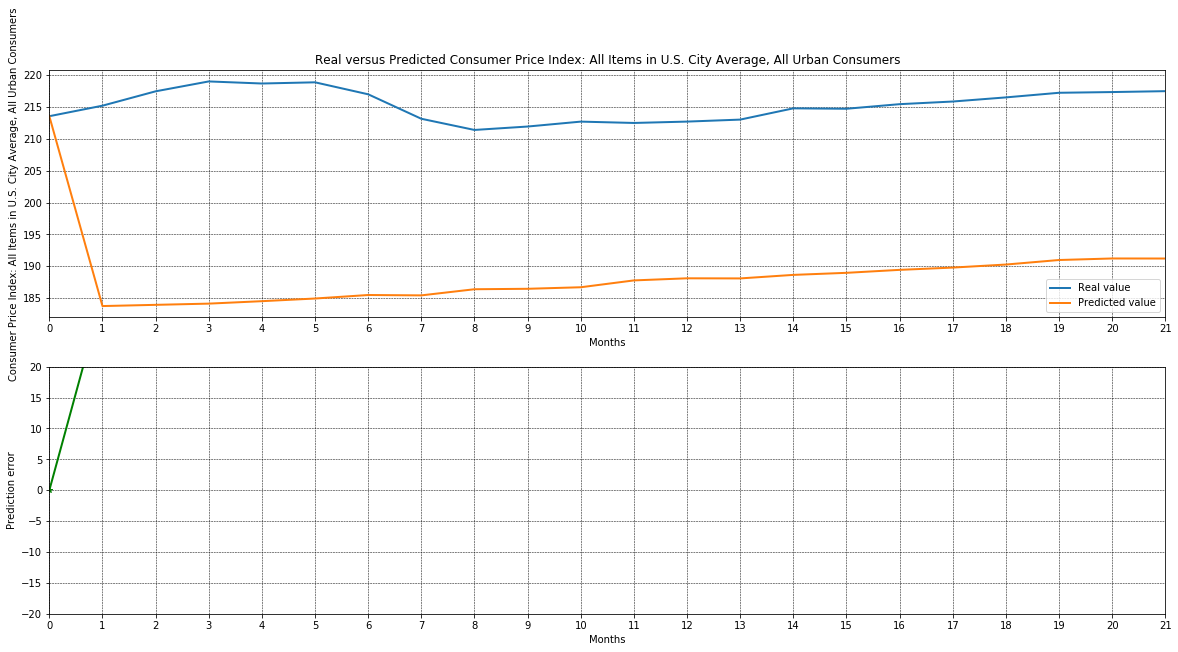

Prediction for 1 Months: MAE = 31.47 (14.62%)
Prediction for 5 Months: MAE = 33.6 (15.42%)
Prediction for 21 Months: MAE = 27.95 (12.97%)


In [10]:
n_steps_jump = 1

X_test, y_test = split_sequence(series_input, n_steps_input, n_steps_forecast, n_steps_jump)
if (NN_str == 'MLP'):
    X_test = np.squeeze(X_test, axis=2)
y_test = np.squeeze(y_test, axis=2)

## ------- TRAIN MODEL WITH ALL DATA-------
model.fit(X_test, y_test, epochs = 200, verbose = 0);

if (NN_str == 'MLP'):
    yhat = model.predict(series_input[-n_steps_input:].T, verbose=0)
else:
    yhat = model.predict(series_input[-n_steps_input:].reshape(1, n_steps_input, 1), verbose=0)

#plt.plot()
y_pred_test = yhat.tolist()
y_pred_test = scaler.inverse_transform(y_pred_test)

predictions_array = np.array(y_pred_test).flatten()
    
real_array = np.array(df_test.values).flatten()

# plot results
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab)
plt.plot(range(0,len(real_array)+1), np.concatenate((np.array(np.squeeze(scaler.inverse_transform([series_input[-1]]), axis=1)), real_array), axis=0), linewidth=2)
plt.plot(range(0,len(predictions_array)+1), np.concatenate((np.array(np.squeeze(scaler.inverse_transform([series_input[-1]]), axis=1)), predictions_array), axis=0), linewidth=2)
plt.xlim([0,len(predictions_array)])
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.plot(range(0,len(real_array-predictions_array)+1), np.concatenate((np.array([0]), real_array-predictions_array), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.xlim([0,len(predictions_array)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.ylim([-20,20])
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

printMAEpred(real_array, predictions_array, daysToForecast)

In [11]:
df_train.values[-10:]

array([[207.603],
       [207.667],
       [208.547],
       [209.19 ],
       [210.834],
       [211.445],
       [212.174],
       [212.687],
       [213.448],
       [213.942]])

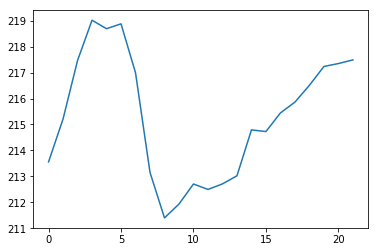

In [12]:
plt.plot(np.concatenate((np.array(np.squeeze(scaler.inverse_transform([series_input[-1]]), axis=1)), real_array), axis=0))